In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, random_split
from data import generate_data, linear_quadratic

In [1]:
0

0

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def running_mean(x, N=100):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

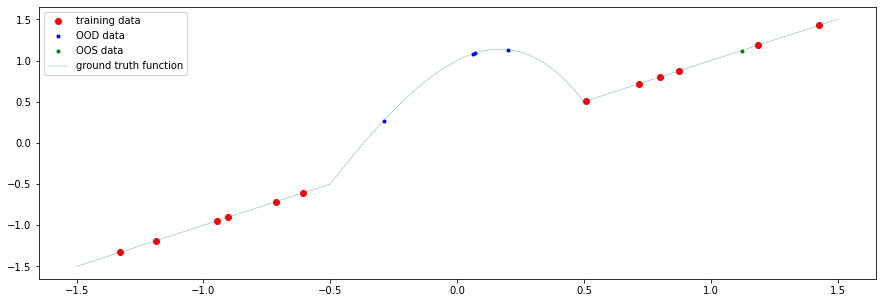

In [103]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(12, 2, 8, seed=8, plot=True, device=device, shuffle=True, one_sine=False, oracle=linear_quadratic)

full_X = torch.cat((x, ood_x, oos_x))
full_Y = torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [104]:
gpr = GaussianProcessRegressor(random_state=0)

In [105]:
gpr.fit(x.cpu().numpy(), y.cpu().squeeze().numpy())

GaussianProcessRegressor(random_state=0)

In [106]:
predictions, std_predictions = gpr.predict(x_test.cpu().numpy(), return_std=True)

In [107]:
residuals = gpr.predict(full_X.cpu().numpy()) - full_Y.cpu().squeeze().numpy()

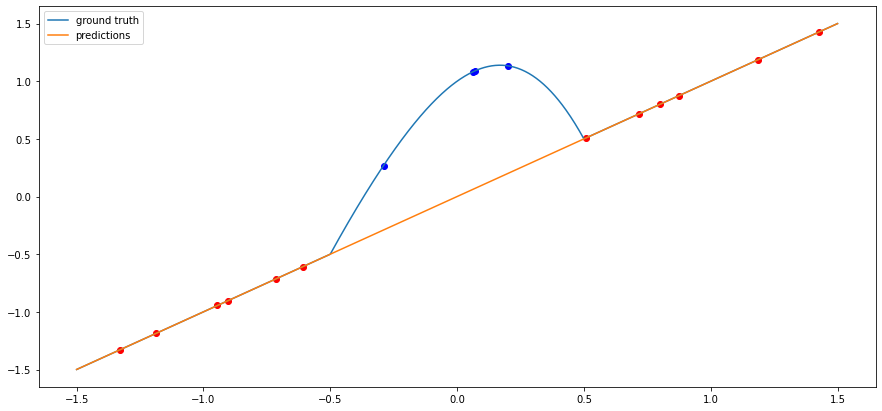

In [108]:
plt.figure(figsize=(15, 7))
plt.plot(x.cpu(), y.cpu().squeeze(), 'ro')
plt.plot(ood_x.cpu(), ood_y.cpu().squeeze(), 'bo')
plt.plot(x_test.cpu(), y_test.cpu(), label='ground truth')
plt.plot(x_test.cpu(), predictions, label='predictions')
# plt.fill_between(x_test.squeeze().cpu(), predictions - std_predictions, predictions + std_predictions, alpha=.3)
plt.legend()
plt.show()

In [109]:
residuals

array([-4.66744348e-08,  1.79634420e-07,  2.12366725e-07,  7.90053672e-07,
       -3.02709174e-07,  4.54365553e-07, -1.34926872e-06, -5.30716289e-07,
       -3.64531322e-07, -1.13402372e-06,  8.63880284e-07,  1.22762703e-06,
       -1.01945470e+00, -9.32043128e-01, -5.58396653e-01, -1.01933609e+00,
       -8.71306569e-06])

In [110]:
cov = .9 * np.outer(residuals, residuals) + .1 * np.abs(residuals) ** 2 * np.eye(len(residuals))

In [111]:
L = np.linalg.cholesky(cov)

In [112]:
d = np.random.multivariate_normal(np.zeros(len(residuals)), np.eye(len(residuals)), 9)

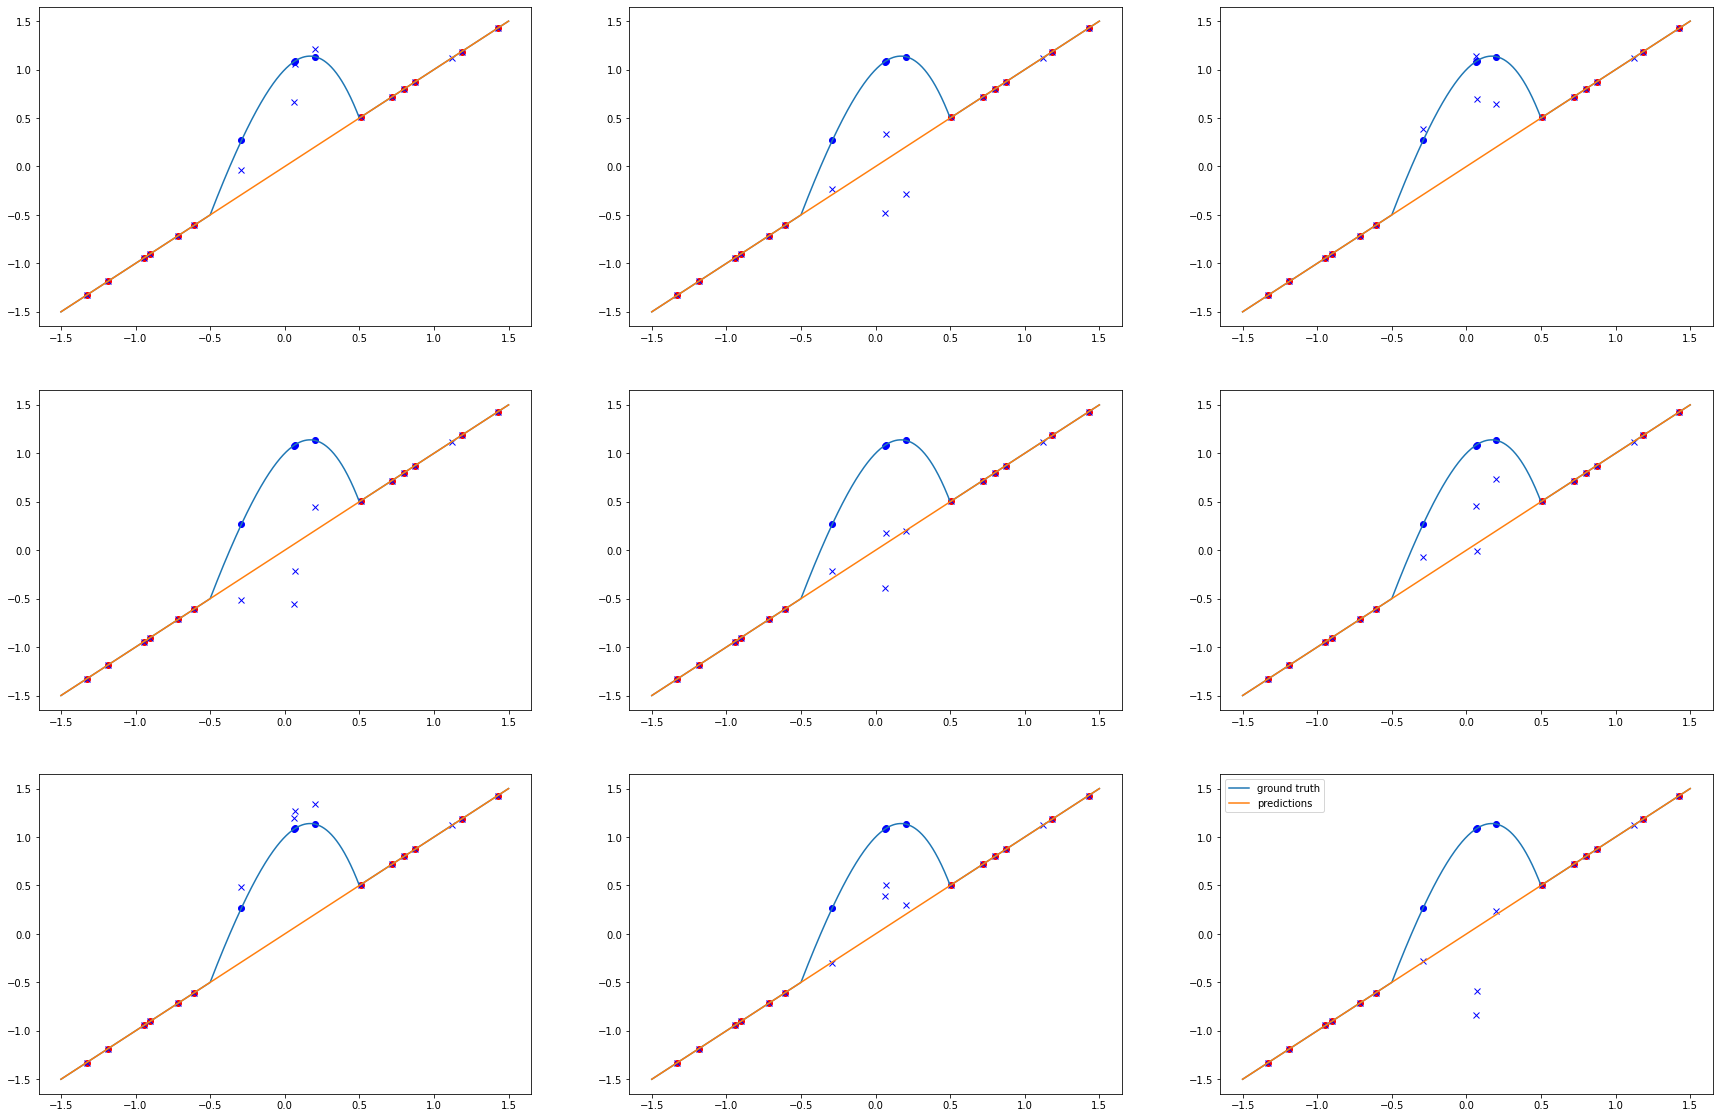

In [113]:
plt.figure(figsize=(30, 20))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.plot(x.cpu(), y.cpu().squeeze(), 'ro')
    plt.plot(ood_x.cpu(), ood_y.cpu().squeeze(), 'bo')
    plt.plot(full_X.cpu(), full_Y.cpu().squeeze().numpy() + L@d[i, :], 'bx')
    plt.plot(x_test.cpu(), y_test.cpu(), label='ground truth')
    plt.plot(x_test.cpu(), predictions, label='predictions')
    # plt.fill_between(x_test.squeeze().cpu(), predictions - std_predictions, predictions + std_predictions, alpha=.3)
plt.legend()
plt.show()

In [135]:
z_dim = 10
hidden_dim = 128
LR = 1e-4
f = nn.Sequential(nn.Linear(1 + z_dim, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, 1)
                 ).to(device=device)
o = torch.optim.Adam(f.parameters(), lr=LR)

In [136]:
EPOCHS = 1000
BS = 10
losses = []
loader = DataLoader(full_data, batch_size=BS, shuffle=True)
for epoch in range(EPOCHS):
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        o.zero_grad()
        
        epsilon = torch.randn(z_dim).to(device=device)
        epsilon_r = epsilon.repeat(xi.shape[0], 1)
        net_in = torch.cat((xi, epsilon_r), 1)
        net_out = f(net_in)
        
        residuals = torch.FloatTensor(gpr.predict(xi.cpu().numpy())).to(device=device) - yi.squeeze()
        cov = .9 * torch.outer(residuals, residuals) + (.1 * (residuals) ** 2 + 1e-6) * torch.eye(len(residuals)).to(device=device)
        L = torch.linalg.cholesky(cov)
        target = yi + L@epsilon[:xi.shape[0]].unsqueeze(-1)
        
        loss = nn.MSELoss()(target, net_out)
        epoch_losses.append(loss.item() * len(xi))
        loss.backward()
        o.step()
    losses.append(np.sum(epoch_losses) / len(full_data))

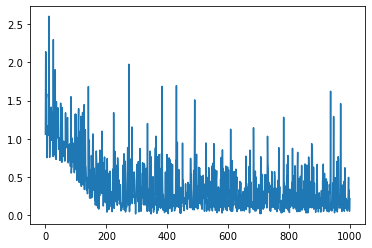

In [137]:
plt.plot(losses)

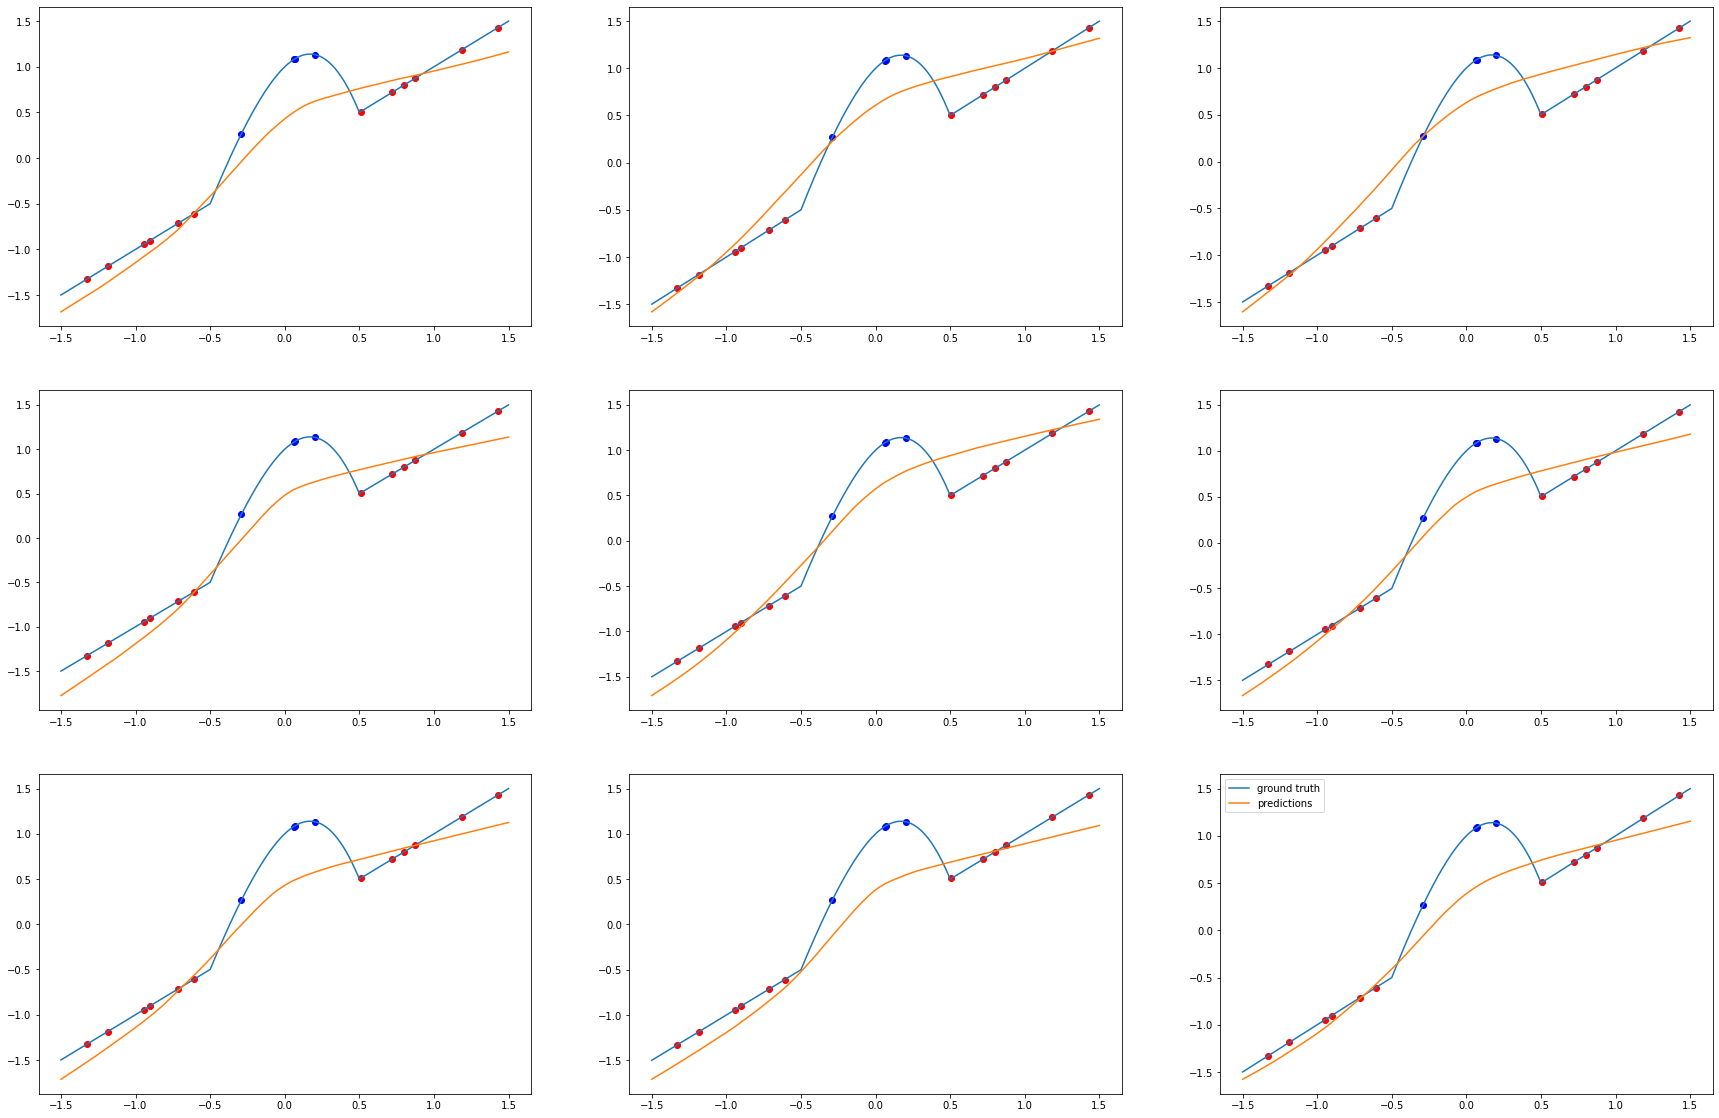

In [138]:
plt.figure(figsize=(30, 20))

for i in range(9):
    epsilon = torch.randn(z_dim).to(device=device)
    epsilon_r = epsilon.repeat(x_test.shape[0], 1)
    plt.subplot(3, 3, i + 1)
    plt.plot(x.cpu(), y.cpu().squeeze(), 'ro')
    plt.plot(ood_x.cpu(), ood_y.cpu().squeeze(), 'bo')
    plt.plot(x_test.cpu(), y_test.cpu(), label='ground truth')
    plt.plot(x_test.cpu(), f(torch.cat((x_test, epsilon_r), 1)).cpu().detach(), label='predictions')
    # plt.fill_between(x_test.squeeze().cpu(), predictions - std_predictions, predictions + std_predictions, alpha=.3)
plt.legend()
plt.show()

In [72]:
x = torch.randn(5, 1)

In [76]:
torch.cat((x, z), 1).shape

torch.Size([5, 17])